In [1]:
using LogicCircuits
using DataFrames
using BenchmarkTools
using TikzPictures
TikzPictures.standaloneWorkaround(true)

In [2]:
# Return all the 2n semiresolvents of SDD s (with manager m)
function sdd_semiresolvents(s,m)
    output = []
    for i in 1:num_variables(s)
        for sign in [-1,+1]
            sr = LogicCircuit(s)
            sr = condition(sr, Lit(sign*i))
            sr = forget(sr,v->v==i)
            sr2 = compile(m,sr) 
            push!(output,sr2)
        end
    end
    return output
end

# Expand the array v by replacing each element with all the semiresolvents (with manager m)
function sdd_expander(v,m)
    output = []
    for s in v
        for k in sdd_semiresolvents(s,m)
            push!(output,k)        
        end
    end
    return output
end

function sdd_revision(s,s1,m)
    k = 0
    compatibles = []
    n = num_variables(s)
    revision_ok = false
    push!(compatibles,s)
    if typeof(conjoin(s,s1)) == SddFalseNode     # New KB is incompatible, revision is needed    
        while !revision_ok
            k = k + 1
            compatibles2 = sdd_expander(compatibles,m)
            compatibles3 = []
            for sr in compatibles2
                sr2 = compile(m,sr)
                rev = conjoin(sr2,s1)
                if !(typeof(rev)==SddFalseNode)
                    push!(compatibles3,sr2)
                    revision_ok = true
                end
            end
            if revision_ok
                compatibles = compatibles3
            else
                compatibles = compatibles2
            end        
        end
    end
    rev = compile(m,false)
    for compatible in compatibles
        rev = disjoin(rev,compatible)
    end
    rev = conjoin(rev,s1)
    println("k=",k)
    return rev
end

function random_cnf(literals, d, n)
        clauses = rand(1:length(literals),d,n)
        formula = LogicCircuit(true)
        for j in 1:d
                clause = LogicCircuit(false)
                for i = 1:n
                        if rand(Bool, 1)[1]
                                clause |= literals[clauses[j,i]]
                        else
                                clause |= !literals[clauses[j,i]]
                        end
                end
                formula &= clause
        end
        return formula
end

random_cnf (generic function with 1 method)

k=1
2

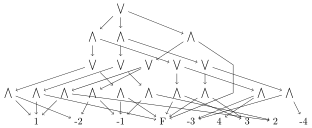

In [10]:
nvars = 4
L = LogicCircuit(Lit(1))
K = LogicCircuit(Lit(2))
P = LogicCircuit(Lit(3))
A = LogicCircuit(Lit(4))

vtree2 = PlainVtree(nvars, :balanced)
manager = SddMgr(vtree2)

psi = (L | P) & ( !A | P ) & ( !K |(A|L)) # Example for Kisa et al. 2014
S = compile(manager, psi); #sdd

#mu = (!L & K & P & A) | (L & K & P & A) # compatible (both)
mu = (!L & K & !P & !A) | (L & !K & !P & A) # compatible (single)
#mu = (!L & K & !P & A) | (L & !K & !P & A) # incompatible
S1 = compile(manager, mu); #sdd
S2 = sdd_revision(S,S1,manager)
print(model_count(S2))
plot(S2)

In [ ]:
n_bools = 10;  #10;
phi_size = n_bools*2; #25;
mu_size = n_bools*2;  #25;
sat_size = 3;
l = [LogicCircuit(Lit(i)) for i in 1:n_bools];
vtree = PlainVtree(n_bools, :balanced);
manager = SddMgr(vtree);
for i = 1:10
    psi = random_cnf(l,phi_size,sat_size);
    mu = random_cnf(l,mu_size,sat_size);
    sdd_psi = compile(manager, psi);
    sdd_mu = compile(manager, mu);
    sdd_rev = sdd_revision(sdd_psi,sdd_mu,manager);
    print("n_mu=",model_count(sdd_mu))
    print(" n_psi=",model_count(sdd_psi))
    println(" n_rev=",model_count(sdd_rev))    
end